In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
import geopandas as gpd
from shapely import wkt
import pandas as pd
import random
from shapely.geometry import Polygon, Point

In [54]:
data = pd.read_csv('data_with_gadm.csv')

# Convert 'geometry' column to GeoSeries
data['geometry'] = data['geometry'].apply(wkt.loads)
geometry = gpd.GeoSeries(data['geometry'])
gdf = gpd.GeoDataFrame(data, geometry=geometry)

In [55]:
# Hàm tạo tọa độ ngẫu nhiên trong đa giác
def random_point_in_polygon(polygon):
    minx, miny, maxx, maxy = polygon.bounds
    while True:
        pnt = gpd.points_from_xy([random.uniform(minx, maxx)], [random.uniform(miny, maxy)])[0]
        if polygon.contains(pnt):
            return pnt

In [65]:
# Tạo cột tọa độ ngẫu nhiên
gdf['random_point'] = gdf['geometry'].apply(random_point_in_polygon)
gdf['random_point'] = gdf['random_point'].apply(lambda p: f'({p.x}, {p.y})')
# Extract coordinates
coordinates = np.array([eval(point) for point in gdf['random_point']])

In [68]:
# Create KDE
kde = KernelDensity(bandwidth=0.02, metric='euclidean')
kde.fit(coordinates)

# Evaluate KDE on a grid
xmin, ymin, xmax, ymax = gdf.total_bounds
xgrid = np.linspace(xmin + 0.1, xmax + 0.05, 100)
ygrid = np.linspace(ymin + 0.1, ymax + 0.05, 100)
X, Y = np.meshgrid(xgrid, ygrid)
xy_sample = np.vstack([X.ravel(), Y.ravel()]).T
Z = kde.score_samples(xy_sample)
Z = np.exp(Z).reshape(X.shape)

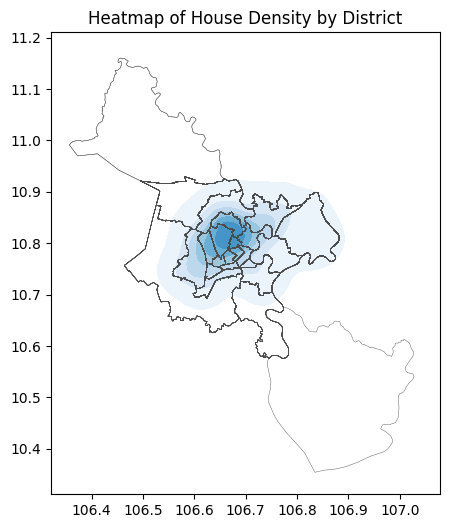

In [75]:
# Plot heatmap
fig, ax = plt.subplots(figsize=(8, 6))
plt.contourf(X, Y, Z, levels = np.linspace(1, 100, 10),  cmap='Blues')
plt.title('Heatmap of House Density by District')
# Plot district boundaries
gdf.boundary.plot(ax=plt.gca(), linewidth = 0.3, edgecolor = '0.3')
# gdf.plot(linewidth=0.8, ax=ax, edgecolor='0.3', legend=True)

plt.show()